# Classification of queries with Entity Types

### The goal

Search queries offer an opportunity to see into the collective mind of internet users. We ask: How can we use this rich aggregate data to gain insight into what people are thinking when they ask the oracle of Google their most pressing questions? To find out, we will classify queries according to broad topics based on the most salient entities that they contain.

### The reasoning

A classification of searches will help us understand our user base, what they're looking for, and why. We'll be able to uncover inter- and intra-user patterns, as well as connections between subjects that may not be obvious on the face of the queries.

### The method

* Preprocess the corpus using NLP techniques like tokenization, lemmatization, stopword removal, etc.
* Examine the data using statistical and probabilistic distributions to uncover patterns
* Engineer features to exploit relationships between variables
* Annotate the queries with entity types using probabilistic named entity recognition 
* Train a neural network to classify queries according to engineered labels


### Techniques, frameworks, and modeling

* spaCy: State-of-the-art, fast, based on C, good for streamlining large corpora and iterating quickly with pretrained models that can be updated online
* Keras: Similarly good for quick sketches of models that can later be fleshed out more fully
* Text classification: Multi-class classification is valuable technique for this kind of problem, and neural networks are a cutting-edge technology in NLP today (see BERT, for example). It behooves us to learn how to use these processes with text data!

### The outcome

With stochastic gradient descent and categorical cross-entropy as our learning and loss functions, The model achieved high accuracy -- but with only a few features for input, it's hard to have great recall with lots of categories. More feature engineering and domain knowledge will help us iterate to improve the model.

# Importing and Exploring the Data

In [1]:
import string
import requests
import io
from collections import Counter, deque

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("dark")

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

import spacy
from spacy.tokens import Doc
from spacy.matcher import Matcher
from spacy.tokens import Token
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Importing training data

In [2]:
def get_github_data(url, sep="\t"):
    data = requests.get(url).content
    df = pd.read_csv(io.StringIO(data.decode("utf-8")), sep=sep, header=None)
    return df

In [3]:
train_data = requests.get("https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/train.tsv").content
df = pd.read_csv(io.StringIO(train_data.decode('utf-8')), sep="\t", header=None, names=["query", "score"])

## Exploring the data

It's always prudent to begin with some basic exploration of the dataframe:

1. Preview the first several rows
2. Get basic info on the size, shape, and data types in the set
3. Preview summary statistics
4. Check for null values

In [4]:
df.head(10)

query  score
0             The European Union includes how many ?    0.2
1                What are Mia Hamms accomplishment ?    0.4
2  Which form of government is still in place in ...    1.0
3               When was the canal de panama built ?    0.8
4  What color is the black box on commercial aero...    0.6
5                 An element on the periodic table ?    0.2
6                  How did samoans come into samoa ?    0.8
7                           Who disscoverd rihanna ?    0.2
8                      Modern day meter is defined ?    0.0
9  What is the value of military payment certific...    0.8

We'll want to know the relative lengths of queries. Before doing NLP preprocessing, we can get a rough approximation of the number of words in each query by counting the spaces in each string (the space before the final punctuation accounts for the last word).

In [5]:
df["wpq"] = df["query"].str.count(" ")

In [6]:
df.isna().any()

query    False
score    False
wpq      False
dtype: bool

We can already see that the data are not normally distributed; there are a few very long outlier queries, and lots of short ones, with a natural lower bound of zero: 

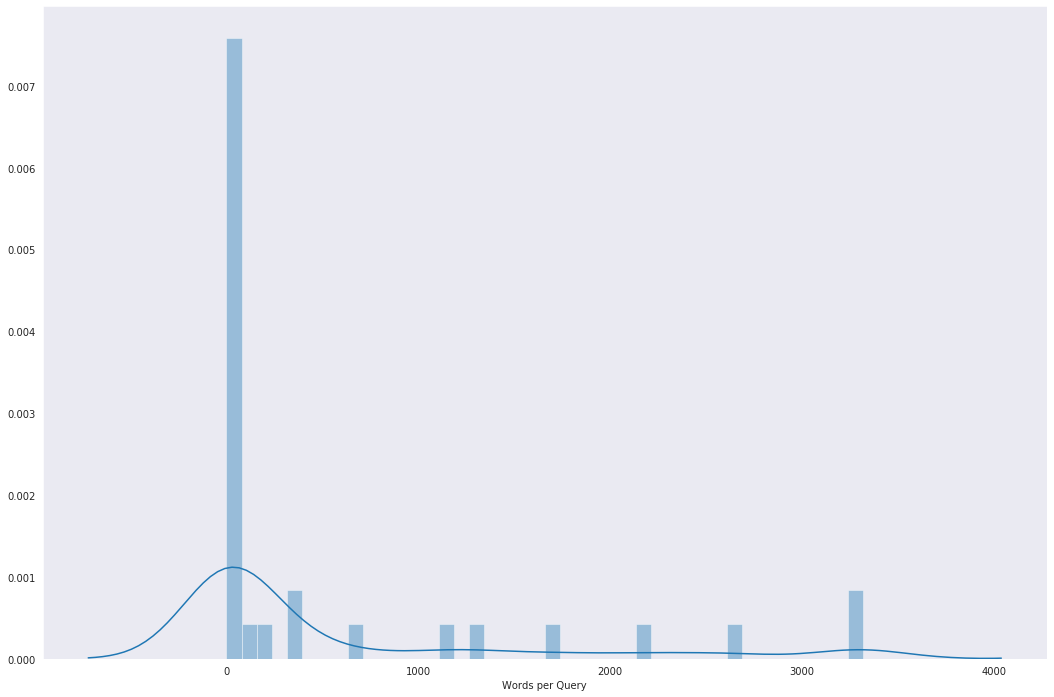

In [7]:
plt.figure(figsize=(18,12))
sns.distplot(df.wpq.value_counts(), bins=42, axlabel="Words per Query")
plt.show();

In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 3 columns):
query    17500 non-null object
score    17500 non-null float64
wpq      17500 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 410.3+ KB


score           wpq
count  17500.000000  17500.000000
mean       0.508331      7.258800
std        0.379398      2.413921
min        0.000000      1.000000
25%        0.200000      6.000000
50%        0.600000      7.000000
75%        0.800000      8.000000
max        1.000000     33.000000

Here we see again the right skew of the word count. The longest query weighs in at 33 words, and the shortest at 1.

In [9]:
# "https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/train.tsv"

In [10]:
def m3_stats(series):
    print(f"Summary statistics, {series.name}:\n")
    print(f"Mean:\t{round(series.mean(), 3)}")
    print(f"Median:\t{series.median()}")
    print(f"Mode:\t{series.mode().iloc[0]}")

In [11]:
m3_stats(df.wpq)

Summary statistics, wpq:

Mean:	7.259
Median:	7.0
Mode:	6


The scores for queries are similarly right-skewed.

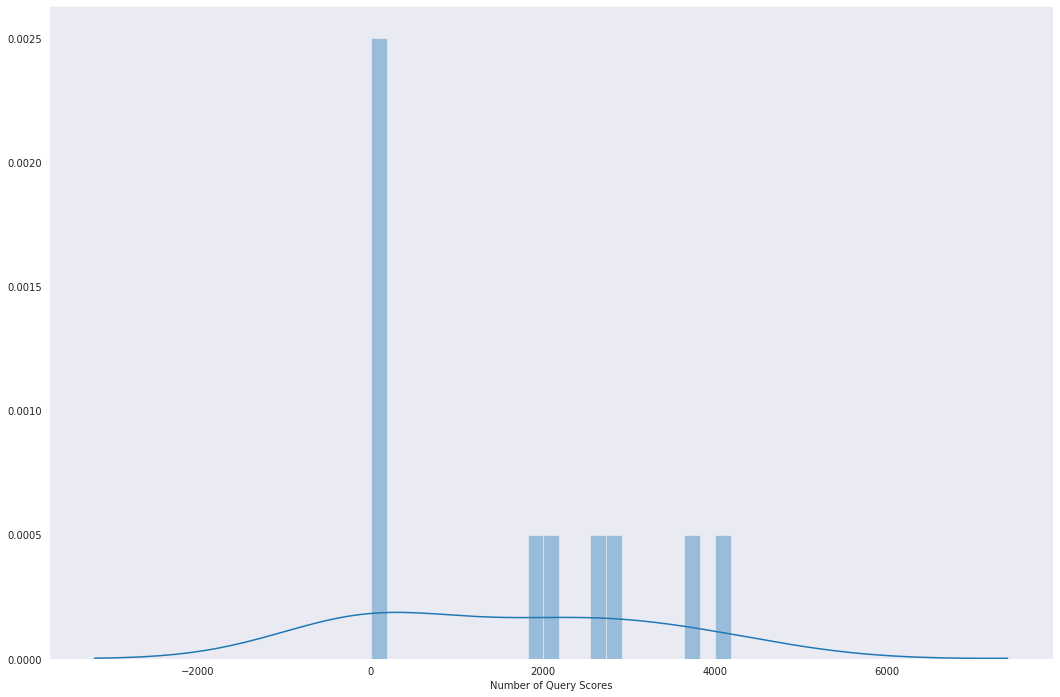

In [12]:
import numpy as np
plt.figure(figsize=(18,12))
sns.distplot(df.score.value_counts(), bins=23, axlabel="Number of Query Scores")
plt.show();

## Summary statistics

In [13]:
m3_stats(df.score)

Summary statistics, score:

Mean:	0.508
Median:	0.6
Mode:	1.0


In [14]:
#Log transforming the counts of score and length produces a less skewed distribution.
score_log = np.log(df.score.replace(0, 1e-12))
wpq_log = np.log(df.wpq)

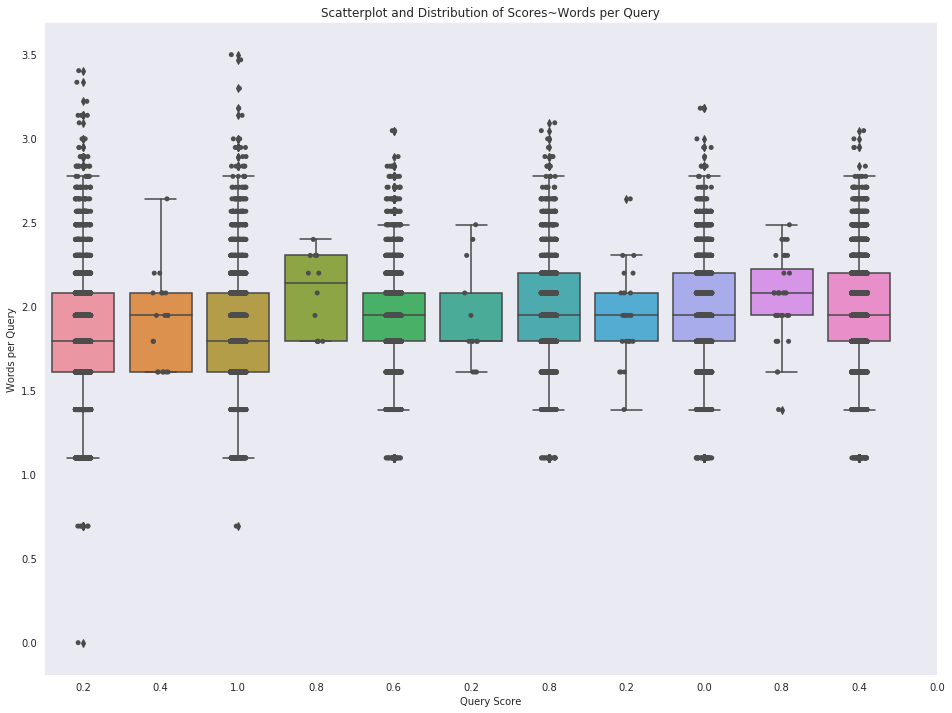

In [15]:
labels = df.score.apply(lambda x: "{0:.3}".format(x)).values
plt.figure(figsize=(16,12))
ax = sns.boxplot(y=wpq_log, x=score_log)
ax = sns.stripplot(y=wpq_log, x=score_log, jitter=True, color=".3")
plt.xticks(ticks=np.arange(12), labels=labels)
#print(plt.xticks())
plt.title("Scatterplot and Distribution of Scores~Words per Query")
plt.xlabel("Query Score")
plt.ylabel("Words per Query")
plt.show()

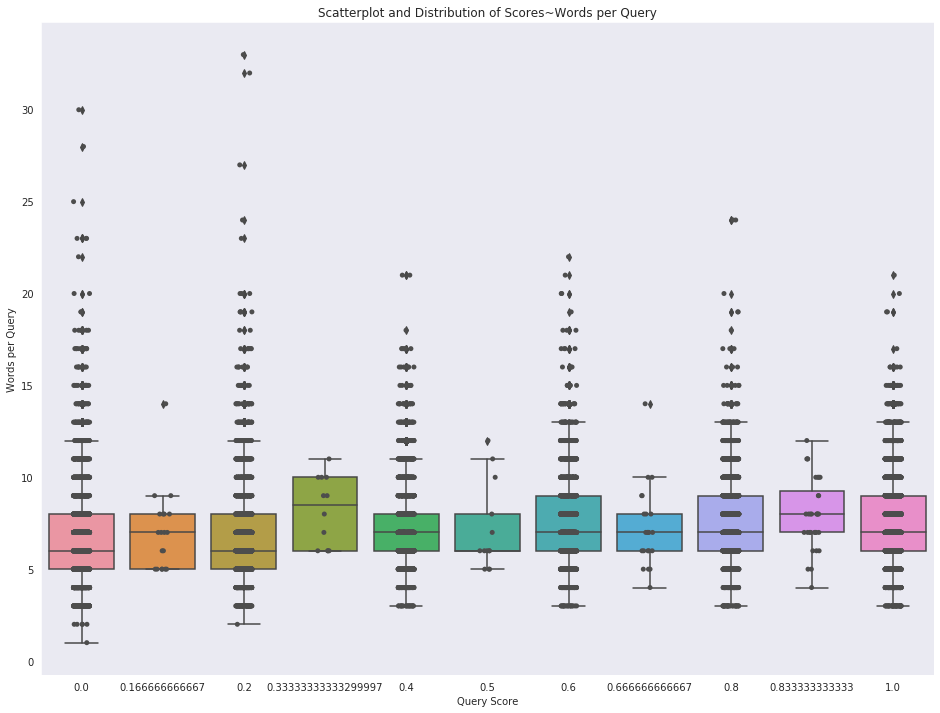

In [16]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(16,12))
ax = sns.boxplot(x="score", y="wpq", data=df)
ax = sns.stripplot(x="score", y="wpq", data=df, jitter=True, color=".3")
#ax.xaxis.set_major_formatter(FormatStrFormatter('%4.3f'))
plt.title("Scatterplot and Distribution of Scores~Words per Query")
plt.xlabel("Query Score")
plt.ylabel("Words per Query")
plt.show()

# Categorizing queries according to their semantics using named entity recognition


We'll use spaCy to tag the entities in our queries to engineer categories and build a query classifier to categorize our data into semantic question classes.


## Linguistic Preprocessing

### The critical basis for analysis

To provide meaningful insights, unstructured language data must be deliberately and thoughtfully preprocessed.

To calculate the probabilities of a query falling in a certain category, the query strings should be split into lexemes and tagged for part of speech. 
Entity extraction will also prove to be a useful feature.

The NLP pipeline consists of removing stopwords, tokenizing, tagging parts of speech, lemmatizing, parsing dependencies, and extracting entities. Once the strings have been tokenized, bigrams and higher-order n-grams can be found to provide additional features.

#### A methodological question: To lemmatize or not to lemmatize

For many kinds of NLP tasks, lemmatization--reducing a word to its citation format--can be desirable, e.g. to eliminate the redundancy of a model in which "run", "runs", and "ran" are all treated as independent random variables. For summarization tasks, however, it can be detrimental.

In [17]:
import nltk
import re
from collections import defaultdict

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import spacy

In [18]:
# Extract our corpus for processing

docs = df["query"].to_list()

In [19]:
# Some cleaning functions that may be 
# useful for processing data, depending on
# the use case!

def remove_punct(doc):
    '''Remove all punctuation.'''
    pattern = re.compile(r"[!\"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~]+")
    doc = re.sub(pattern, r"", doc).rstrip()
    return doc

In [20]:
def remove_Q(doc):
    '''Remove only the terminal question mark and space
    '''
    doc = doc.text
    pattern = re.compile(r"(.+)(?=\s\?)")    
    try:
        new = pattern.match(doc).expand(r"\g<1>")
    except Exception as e:
        print(doc)
        print(e)
        
    return nlp.make_doc(new)

In [21]:
c_docs = list(map(remove_punct, docs))

In [22]:
nlp = spacy.load("en_core_web_lg")

In [23]:
spacy_docs = list(nlp.pipe(c_docs))

For dependency parsing, stop words are not removed, as this would destroy the syntactic structure and leave us with only a 'bag of words' -- which, for very short texts, may obscure information. 

However, a lexeme frequency count will be a useful metric, for which the tokens are lemmatized to prevent under-counting. Some lexemes commonly treated as stop words (e.g., interrogative adverbs) are important to retain for analyzing queries, so their tags will be retained.

In [24]:
def clean_doc(doc, lemmas=True):
    '''
    Input: a spacy doc
    Purpose: remove words too common to impart additional information
    Output: a stopword-cleaned spacy doc, with or without lemmatization
    '''
    if lemmas == True:
        return nlp.make_doc(" ".join([token.lemma_ for token in doc 
                                  if not (token.is_stop or token.is_punct)or token.tag_ in ["EX", "RBR", "RBS", "WDT", "WP", "WP$", "WRB"] or token.pos_ in ["NUM"]]))
    else:
        return nlp.make_doc(" ".join([token.lemma_ for token in doc if not token.is_stop or token.tag_ in ["EX", "RBR", "RBS", "WDT", "WP", "WP$", "WRB"] or token.pos_ in ["NUM"]]))

cleaned_docs = [clean_doc(doc) for doc in spacy_docs]

In [25]:
# Preview the docs
print(spacy_docs[:20])
print(cleaned_docs[:20])

[The European Union includes how many, What are Mia Hamms accomplishment, Which form of government is still in place in greece, When was the canal de panama built, What color is the black box on commercial aeroplane, An element on the periodic table, How did samoans come into samoa, Who disscoverd rihanna, Modern day meter is defined, What is the value of military payment certificate series 661, Adjective starts with the letter e, Population of owls just in north america, What is ireland s favorite foods, How do you remove the stereo in a hyundai elantre, When did herbert walker bush die, Huge flowers that start with letter C, What is the sound quality of the oboe, How do you become a more confident, What is the harp seal pups weight, Can you catch mew three in emerald]
[European Union include how, what Mia Hamms accomplishment, which form government place greece, when canal de panama build, what color black box commercial aeroplane, element periodic table, how samoan come samoa, who d

### Grammaticality feature

One feature that has been engineered is a rough judgment of grammaticality, based on the presence of a subject/noun phrase and predicate/verb phrase in the correct order. This is achieved using the dependency parser. It would be a useful feature, for example, in text generation, autocompletion, or autocorrection of search queries. 

In [26]:
def is_grammatical(tags, doc):
    tokens = iter(doc)
    try:
        for tag in tags:
            tag = set(tag)
            while next(tokens).dep_ not in tag:
                pass
        else:
            return True
    except StopIteration as e:
        pass
    return False

In [27]:
from spacy.glossary import GLOSSARY
all_ids = list(GLOSSARY.keys())
all_tags = list(nlp.tokenizer.vocab.morphology.tag_names)

In [28]:
total = all_tags+all_ids

In [29]:
df["is_grammatical"] = False
tags = [["attr","nsubj","nsubjpass","advmod","WDT","WP", "WP$","WRB"],
        ["VBD", "VBG", "VBN", "VBP", "VB", "VBZ","ROOT"],total]
pred = ["VBD", "VBG", "VBN", "VBP", "VB", "VBZ","ROOT"]
nom = ["attr","nsubj","nsubjpass","advmod","WDT","WP", "WP$","WRB"]
for i in range(len(spacy_docs)):
    #if check_tags.issubset(token.dep_ for token in spacy_docs[i]):
    if is_grammatical(tags, spacy_docs[i]):
        df.loc[i, "is_grammatical"] = True

In [30]:
df.is_grammatical.value_counts()

True     12749
False     4751
Name: is_grammatical, dtype: int64

In [31]:
gram_filt = df.is_grammatical == False
false_gram = df[gram_filt]

In [32]:
false_tags = [["WP", "WRB", "VBZ", "VBP", "MD", "aux", "auxpass"],["attr","nsubj",
                "nsubjpass","advmod","WDT","WP", "WP$","WRB","VBD", "VBG", "VBN", "VBP", "VB", "VBZ"],total]

In [33]:
false_pos = false_gram.index.to_list()
recheck = [spacy_docs[i] for i in false_pos]
count = 0
for i in range(len(recheck)):
    if is_grammatical(false_tags, recheck[i]):
        df.loc[i, "is_grammatical"] = True
        count += 1
print(f"Corrected {count} false positives.")

Corrected 258 false positives.


In [34]:
# as a function:
def check_grammar(df, docs):
    df["is_grammatical"] = False
    
    all_ids = list(GLOSSARY.keys())
    all_tags = list(nlp.tokenizer.vocab.morphology.tag_names)
    total = all_tags+all_ids
    tags = [["attr","nsubj","nsubjpass","advmod","WDT","WP", "WP$","WRB"],
        ["VBD", "VBG", "VBN", "VBP", "VB", "VBZ","ROOT"],total]
    pred = ["VBD", "VBG", "VBN", "VBP", "VB", "VBZ","ROOT"]
    nom = ["attr","nsubj","nsubjpass","advmod","WDT","WP", "WP$","WRB"]
    for i in range(len(df)):
        if is_grammatical(tags, docs[i]):
            df.loc[i, "is_grammatical"] = True
    false_tags = [["WP", "WRB", "VBZ", "VBP", "MD", "aux", "auxpass"],["attr","nsubj",
                "nsubjpass","advmod","WDT","WP", "WP$","WRB","VBD", "VBG", "VBN", "VBP", "VB", "VBZ"],total]
    
    false_pos = df[df.is_grammatical == False].index.to_list()
    recheck = [docs[i] for i in false_pos]
    for i in range(len(recheck)):
        if is_grammatical(false_tags, recheck[i]):
            df.loc[i, "is_grammatical"] = True
    return df

The frequency counts for the corpus:

In [35]:
freq_dict = Counter()
for doc in cleaned_docs:
    for token in doc:
        freq_dict[token.lower_] += 1

In [36]:
entities=[(i, i.label_) for docs in spacy_docs for i in docs.ents]

In [37]:
from spacy import displacy
for doc in spacy_docs:
    if doc.ents:
        displacy.render(doc, style = "ent",jupyter = True)

## Engineer the target semantic query categories

(N.B.: The entity recognition is imperfect, and requires a new model to be trained/updated to improve the accuracy.)

We'll tag the queries with the entity types that represent them, and categorize them as being "about" these classes of things. This would be useful information for a business that's trying to find out what its customers are searching for -- we could eventually figure out which kinds of searches are correlated and predict what semantic searches will follow others, for example!

Here, in the case of queries with multiple tags, we'll choose the first tag in the if-else block. Note that many queries have no entities (another reason to iterate on the NER model), but many do! 

The relative frequency (and, by rough proxy, importance/relevance) of the entity types can be seen in the plot below.

In [38]:
def get_ents(doc):
    '''Function to retrieve named entities from doc.'''
    if doc.ents:
        return [(ent, ent.label_) for ent in doc.ents]

entities = {spacy_docs.index(doc): get_ents(doc) for doc in spacy_docs}
ent_dict = Counter()
for doc in spacy_docs:
    for ent in doc.ents:
        ent_dict[ent.label_] += 1

In [39]:
ents_x = sorted(ent_dict, key=ent_dict.get)
ents_y = sorted(ent_dict.values())

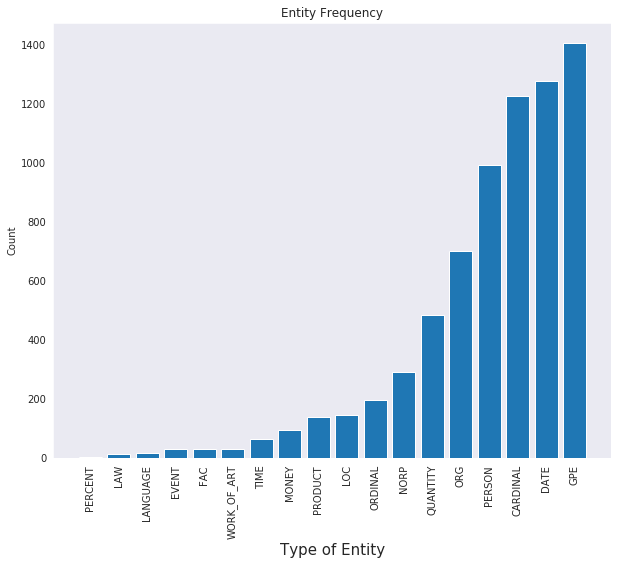

In [40]:
plt.figure(figsize=(10,8))
plt.title("Entity Frequency")
plt.xlabel("Type of Entity", fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation="vertical")
plt.bar(ents_x, ents_y)
plt.show()

In [41]:
from spacy.attrs import intify_attrs
docs_test = spacy_docs
def merge_ents_to_token(doc):
    '''Merges recognized entities into single units for purposes of tokenization.'''
    ents = [(ent.start, ent.end, ent.label)for ent in doc.ents]
    with doc.retokenize() as retokenizer:
        string_store = doc.vocab.strings
        for start, end, label in ents:
            retokenizer.merge(
                doc[start: end],
                attrs=intify_attrs({'ent_type': label}, string_store))
    return doc

for doc in docs_test:
    merge_ents_to_token(doc)

In [42]:
for i in range(len(spacy_docs)):
    assert spacy_docs[i] == docs_test[i]

### Adding the query type label

Here, we add the type label to the dataframe.

In [87]:
def label_query_type(df, spacy_docs):
    '''
    Usage: Group entity types together into broad categories
    
    NORP, LANGUAGE : Culture : 0
    PERSON : Person : 1
    ORG : Organization : 2
    PLACE : Place : 3
    PRODUCT: Product : 4
    DATE, TIME, EVENT: Time : 5
    PERCENT, MONEY, QUANTITY, ORDINAL, CARDINAL: Numeric : 6
    Other: 7 
    '''
    for i in range(len(df)):
        entities =  [ent for ent in spacy_docs[i].ents]
        
        if len(entities) > 0:
            for ent in entities:    
                if ent.label_ in ["NORP", "LANGUAGE"]:
                    df.at[i, "type"] = 0
                elif ent.label_ == "PERSON":
                    df.at[i, "type"] = 1
                elif ent.label_ == "ORG":
                    df.at[i, "type"] = 2
                elif ent.label_ in ["LOC", "GPE"]:
                    df.at[i, "type"] = 3
                elif ent.label_ == "PRODUCT":
                    df.at[i, "type"] = 4
                elif ent.label_ in ["DATE", "TIME", "EVENT"]:
                    df.at[i, "type"] = 5
                elif ent.label_ in ["PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]:
                    df.at[i, "type"] = 6
                else:
                    df.at[i, "type"] = 7
        else:
            df.at[i, "type"] = 7
    
    return df

In [88]:
# A count of the new labels
df = label_query_type(df, spacy_docs)

df["type"].value_counts()

7    11694
6     1676
3     1306
5     1028
1      874
2      538
0      258
4      126
Name: type, dtype: int64

In [89]:
df.head()

query  score  wpq  \
0             The European Union includes how many ?    0.2    6   
1                What are Mia Hamms accomplishment ?    0.4    5   
2  Which form of government is still in place in ...    1.0   10   
3               When was the canal de panama built ?    0.8    7   
4  What color is the black box on commercial aero...    0.6    9   

   is_grammatical type  
0            True    2  
1            True    1  
2            True    3  
3            True    7  
4            True    7

# Text categorization

First, we must create the spaCy pipeline to preprocess the training and test data, prepare it for Keras by vectorizing it. Then, we'll build a Keras neural network to do the categorization. Finally, we'll fit and train the model and examine its output.

## Process data with spaCy (and sklearn)

In [46]:
# add processing as custom pipes
#nlp.remove_pipe("remove_Q")
nlp.add_pipe(remove_Q, after="ner")
#nlp.add_pipe(merge_ents_to_token, last=True)

In [47]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f32f1c2e978>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f32f1542708>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f32f1542768>),
 ('remove_Q', <function __main__.remove_Q(doc)>)]

In [48]:
from itertools import tee
testing_pipeline = nlp.pipe(df["query"].to_list())

nlp_gen0, nlp_gen1 = tee(testing_pipeline)

sklearn_docs = [" ".join([t.text for t in doc]) for doc in nlp_gen0]
spacy_token_docs = list(nlp_gen1)

In [49]:
sklearn_docs[0:4]

['The European Union includes how many',
 'What are Mia Hamms accomplishment',
 'Which form of government is still in place in greece',
 'When was the canal de panama built']

In [50]:
# Vectorize the training docs

# tfidf_vector = TfidfVectorizer(use_idf=True)
# x_train = tfidf_vector.fit_transform(sklearn_docs)

## Create the Keras model

In [52]:
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K, metrics
from sklearn.model_selection import GridSearchCV

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [53]:
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
#y_train = label_encoder.fit_transform(np.array(df["type"]))

In [113]:
y_train = keras.utils.to_categorical(np.array(df["type"]), num_classes=8)

In [114]:
y_train.shape

(17500, 8)

### Fetch the testing data and encode the training and testing data for categorization 

We'll download and transform the test data as well. (This should be refactored into functions to make it DRY, but in the interest of time, I'll leave it as it is!)

We'll need to transform the vocabulary into a format that the model can understand. This model uses TensorFlow to categorize the queries, so we'll need to convert them into sparse matrices. We have used term frequency-inverse document frequency (TF-IDF) count-vectorization to build our input matrices for the neural network, and have encoded our multi-class categories as integer labels.

In [55]:
test_data = requests.get("https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/test.tsv").content
test_df = pd.read_csv(io.StringIO(test_data.decode('utf-8')), sep="\t", header=None, names=["query", "score"])

In [92]:
test_doc_pipeline = nlp.pipe(test_df["query"].to_list())

nlp_gen2, nlp_gen3 = tee(test_doc_pipeline)

sklearn_test_docs = [" ".join([t.text for t in doc]) for doc in nlp_gen2]
spacy_test_docs = list(nlp_gen3)

test_df = label_query_type(test_df,  spacy_test_docs)

# x_test = tfidf_vector.transform(sklearn_test_docs)

In [110]:
# y_test = label_encoder.fit_transform(np.array(test_df["type"]))
y_test = keras.utils.to_categorical(np.array(test_df["type"]), num_classes=8) #.reshape(1, -1)

In [112]:
y_test.shape

(3850, 8)

In [62]:
tokenizer = keras.preprocessing.text.Tokenizer(lower=True, split=' ')

tokenizer.fit_on_texts(" ".join(sklearn_docs))

In [63]:
x_train_keras = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(sklearn_docs), mode="tfidf")
x_test_keras = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(sklearn_test_docs), mode="tfidf")

### Build the classifier model with TensorFlow

The multi-class classifier consists of a simple neural network with an input layer, one hidden layer, and an output layer with softmax activation. We'll optimize using stochastic gradient descent and measure our loss with the categorical cross entropy. Our metrics will be the accuracy of the classification, the reduction in mean squared error, and the resulting cross entropy score.

We use leaky ReLU to avoid the "dead" ReLU problem.

In [123]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.02, clipvalue=0.5, momentum=0.1, nesterov=True)


def make_model(vocab_size, activator="relu", alpha=0.1, optimizer=sgd, 
        dense_layer_size=128, num_layers=1, loss="categorical_crossentropy", 
        metrics=["accuracy", "mse", "categorical_crossentropy"]):

    '''
    
    Usage: create a model with variables for 
    hyperparameters that can be replaced in GridSearch.
    Define anything you want, as long as it would be a 
    valid way to make a single model, then use those
    kwargs as inputs to GridSearch param grid.

    Tip: Set a default value for each kwarg.

    '''
    
    print("Building model . . . ")
    model = Sequential()
    model.add(Dense(512, input_shape=(vocab_size,)))
    model.add(Activation("relu"))
    
    # Add hidden layers
    for i in range(num_layers):
        model.add(Dense(dense_layer_size))
        model.add(keras.layers.LeakyReLU(alpha=alpha))

    # Output layer
    model.add(Dense(df["type"].nunique()))
    model.add(Activation("softmax"))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

model = make_model(x_train_keras.shape[1])
fit_model = model.fit(x=x_train_keras, y=y_train, batch_size=32, epochs=5, verbose=1, validation_split=.2)
score = model.evaluate(x_test_keras, y_test)
print(f"Test score: {score[0]}\nTest accuracy: {score[1]}")

Building model . . . 
Train on 14000 samples, validate on 3500 samples
Epoch 1/5
14000/14000 [==============================] - 4s 257us/step - loss: 1.2388 - acc: 0.6861 - mean_squared_error: 0.0672 - categorical_crossentropy: 1.2388 - val_loss: 1.1564 - val_acc: 0.6903 - val_mean_squared_error: 0.0630 - val_categorical_crossentropy: 1.1564
Epoch 2/5
14000/14000 [==============================] - 3s 194us/step - loss: 1.1421 - acc: 0.6956 - mean_squared_error: 0.0622 - categorical_crossentropy: 1.1421 - val_loss: 1.1493 - val_acc: 0.6906 - val_mean_squared_error: 0.0629 - val_categorical_crossentropy: 1.1493
Epoch 3/5
14000/14000 [==============================] - 3s 190us/step - loss: 1.1379 - acc: 0.6958 - mean_squared_error: 0.0621 - categorical_crossentropy: 1.1379 - val_loss: 1.1464 - val_acc: 0.6909 - val_mean_squared_error: 0.0628 - val_categorical_crossentropy: 1.1464
Epoch 4/5
14000/14000 [==============================] - 3s 193us/step - loss: 1.1361 - acc: 0.6959 - mean_squ

# Conclusions and next steps

We can see that our model has an accuracy of about 96% on the test data and a score of about 50%. There's still a lot of work to do, clearly! Incorporating more of the features we've engineered -- like grammaticality, length, etc. -- and combining the NER data with other features (e.g., types of question words -- "who, what, where" vs. "how", "how many", part of speech like verb/noun/adjective, temporal data, dependency parsing, etc.) will allow us to fine-tune the labeling and get a more accurate categorization!